In [1]:
"""
Created on: Fri. 14 Oct. 2022
Author: Mélina Verger

TO CHANGE. Manually compute a distance between the distributions.
"""

# To load the trained models
import pickle

# For data manipulation
import pandas as pd
import numpy as np

# Plotting module
import seaborn as sns
import matplotlib.pyplot as plt

# To compute area between two curves
import similaritymeasures

In [2]:
# I need the trained models and the different subset of predictions

## Loading

In [2]:
DATA = pickle.load(open("../data/DATA", "rb"))
SPLIT = pickle.load(open("../data/SPLIT", "rb"))

print(DATA)
print(SPLIT)

stInfo
7030


In [3]:
# Load test sets

X_test = pd.read_csv("../data/X_test" + "_" + DATA + "_" + SPLIT + ".csv")
y_test = pd.read_csv("../data/y_test" + "_" + DATA + "_" + SPLIT + ".csv")

In [4]:
# Load trained models

clf_lr = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_lr", "rb"))
clf_svc = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_svc", "rb"))
clf_knearest = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_knearest", "rb"))
clf_dt = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_dt", "rb"))
clf_rf = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_rf", "rb"))

## Separate data sets by (un-)protected groups

At that moment, I chose 'gender', 'imd_band' and 'disability' as interesting features to evaluate fairness with.

In [5]:
X_test_gender_1 = X_test[X_test["gender"] == 1]
X_test_gender_0 = X_test[X_test["gender"] == 0]

y_test_gender_1 = y_test.loc[X_test_gender_1.index]
y_test_gender_0 = y_test.loc[X_test_gender_0.index]

In [6]:
X_test_imdband_1 = X_test[X_test["imd_band"] == 1]
X_test_imdband_0 = X_test[X_test["imd_band"] == 0]

y_test_imdband_1 = y_test.loc[X_test_imdband_1.index]
y_test_imdband_0 = y_test.loc[X_test_imdband_0.index]

In [7]:
X_test_disability_1 = X_test[X_test["disability"] == 1]
X_test_disability_0 = X_test[X_test["disability"] == 0]

y_test_disability_1 = y_test.loc[X_test_disability_1.index]
y_test_disability_0 = y_test.loc[X_test_disability_0.index]

## Manually compute the "distance vector"

### Predictions

In [9]:
y_pred_lr_gender_1 = clf_lr.predict(X_test_gender_1)
y_pred_svc_gender_1 = clf_svc.predict(X_test_gender_1)
y_pred_knearest_gender_1 = clf_knearest.predict(X_test_gender_1)
y_pred_dt_gender_1 = clf_dt.predict(X_test_gender_1)

y_pred_lr_gender_0 = clf_lr.predict(X_test_gender_0)
y_pred_svc_gender_0 = clf_svc.predict(X_test_gender_0)
y_pred_knearest_gender_0 = clf_knearest.predict(X_test_gender_0)
y_pred_dt_gender_0 = clf_dt.predict(X_test_gender_0)

/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value

In [10]:
y_pred_lr_imdband_1 = clf_lr.predict(X_test_imdband_1)
y_pred_svc_imdband_1 = clf_svc.predict(X_test_imdband_1)
y_pred_knearest_imdband_1 = clf_knearest.predict(X_test_imdband_1)
y_pred_dt_imdband_1 = clf_dt.predict(X_test_imdband_1)

y_pred_lr_imdband_0 = clf_lr.predict(X_test_imdband_0)
y_pred_svc_imdband_0 = clf_svc.predict(X_test_imdband_0)
y_pred_knearest_imdband_0 = clf_knearest.predict(X_test_imdband_0)
y_pred_dt_imdband_0 = clf_dt.predict(X_test_imdband_0)

/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value

In [11]:
y_pred_lr_disability_1 = clf_lr.predict(X_test_disability_1)
y_pred_svc_disability_1 = clf_svc.predict(X_test_disability_1)
y_pred_knearest_disability_1 = clf_knearest.predict(X_test_disability_1)
y_pred_dt_disability_1 = clf_dt.predict(X_test_disability_1)

y_pred_lr_disability_0 = clf_lr.predict(X_test_disability_0)
y_pred_svc_disability_0 = clf_svc.predict(X_test_disability_0)
y_pred_knearest_disability_0 = clf_knearest.predict(X_test_disability_0)
y_pred_dt_disability_0 = clf_dt.predict(X_test_disability_0)

/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/melinaverger/Desktop/exp2/env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value

In [15]:
clf_lr.predict_proba(X_test_gender_0)

array([[0.47700411, 0.52299589],
       [0.33075709, 0.66924291],
       [0.36601589, 0.63398411],
       ...,
       [0.46124075, 0.53875925],
       [0.53660166, 0.46339834],
       [0.37783147, 0.62216853]])

## Plotting

In [9]:
models = [clf_lr, clf_knearest, clf_dt, clf_rf]

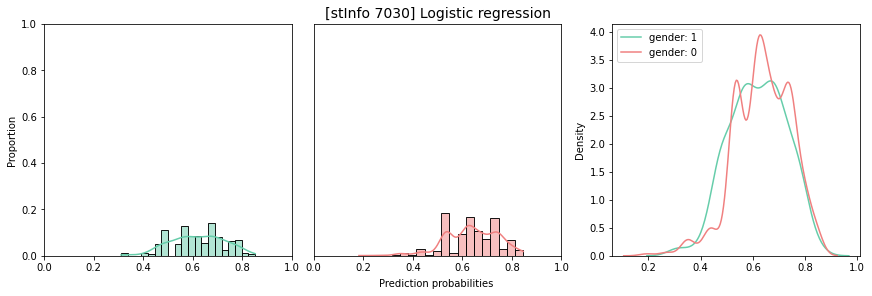

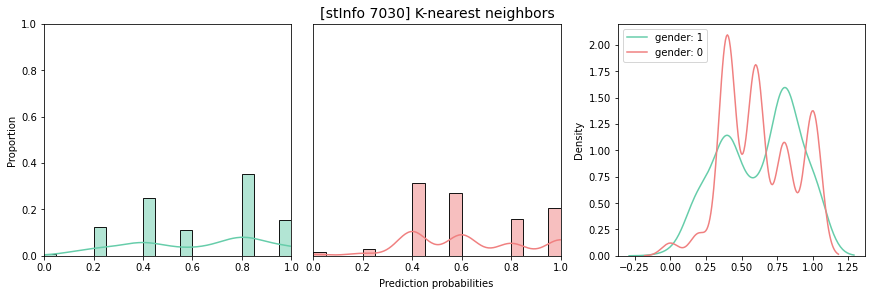

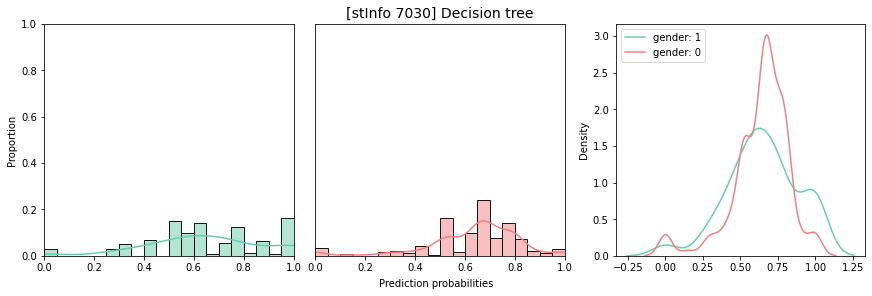

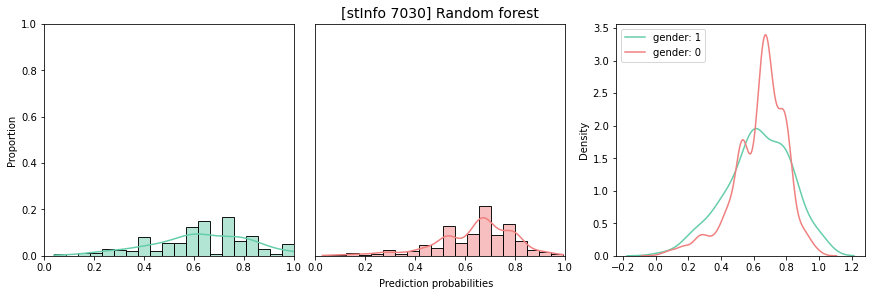

In [10]:
# Gender

for model in models:

    if model == clf_lr:
        model_name = "Logistic regression"
    elif model == clf_knearest:
        model_name = "K-nearest neighbors"
    elif model == clf_dt:
        model_name = "Decision tree"
    else:
        model_name = "Random forest"
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    fig.supxlabel("Prediction probabilities", fontsize=10)
    ax0 = sns.histplot(ax=axes[0], data=model.predict_proba(X_test_gender_1)[:, 1], kde=True, stat="proportion", color="mediumaquamarine", bins=20)
    ax0.set_ylim(0, 1)
    ax0.set_xlim(0, 1)
    ax1 = sns.histplot(ax=axes[1], data=model.predict_proba(X_test_gender_0)[:, 1], kde=True, stat="proportion", color="lightcoral", bins=20)
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 1)
    ax1.set_yticklabels([]) # turn off y ticks labels
    ax1.yaxis.set_visible(False)
    ax2 = sns.kdeplot(ax=axes[2], data=model.predict_proba(X_test_gender_1)[:, 1], color="mediumaquamarine", label="gender: 1")
    ax2 = sns.kdeplot(ax=axes[2], data=model.predict_proba(X_test_gender_0)[:, 1], color="lightcoral", label="gender: 0")
    plt.legend(loc="upper left")
    ax1.set_title(f"[{DATA} {SPLIT}] {model_name}", loc="center", fontsize=14)
    

## Normalized Euclidian distance and areas

In [11]:
def euclidian_distance(vector1, vector2):
    x1 = vector1[:,0]
    y1 = vector1[:,1]

    x2 = vector2[:,0]
    y2 = vector2[:,1]

    dist_vect = np.sum((x2 - x1)**2 + (y2 - y1)**2)

    return np.sqrt(dist_vect)

In [60]:
coordinates1[-1, 0]

1.4801805653869058

-----LogisticRegression(random_state=0)-----
similaritymeasures:
area.: 0.73
IoU.: 0.62
eucl.: 22.91


min and max:
area.: 0.85
IoU.: 0.72
norm. eucl.: 0.45
min maximal from coord1
max minimal from coord1
0.039716538064903606
1.1224293363437607
143
0.040809872126553126
857


ValueError: operands could not be broadcast together with shapes (1000,2) (857,2) 

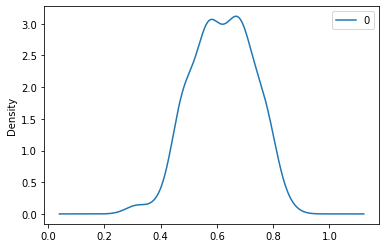

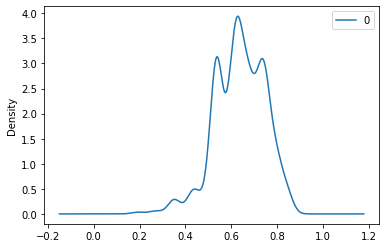

In [70]:
# Gender

for model in models:

   print(f"-----{str(model)}-----", flush=True)
   # retrive curve objects
   line1 = pd.DataFrame(model.predict_proba(X_test_gender_1)[:, 1]).plot.kde()
   line2 = pd.DataFrame(model.predict_proba(X_test_gender_0)[:, 1]).plot.kde()

   # retrieve coordinates
   coordinates1 = line1.get_children()[0].get_path().vertices
   coordinates2 = line2.get_children()[0].get_path().vertices

   # area between curve 1 and curve 2 via their coordinates
   area = similaritymeasures.area_between_two_curves(coordinates1, coordinates2)

   # area of the union of the 2 curves (max. pt1 and pt2)
   coord_max = np.maximum(coordinates1, coordinates2) # element-wise
   xaxis = np.zeros((len(coord_max), 2))
   xaxis[:, 0] = np.linspace(0, 1, num=len(coord_max), endpoint=True)

   area_union = similaritymeasures.area_between_two_curves(coord_max, xaxis)

   print("similaritymeasures:", flush=True)
   print("area.:", round(area_union - area, 2), flush=True) # intersection area

   print("IoU.:", round((area_union - area)/area_union, 2), flush=True) # intersection area over union

   print("eucl.:", round(np.linalg.norm(coordinates2 - coordinates1), 2)) # euclidian distance with primitive function, same results no matter the ordi of the substraction

   normalized_coordinates1 = coordinates1/np.linalg.norm(coordinates1)
   normalized_coordinates2 = coordinates2/np.linalg.norm(coordinates2)
   
   

   print("\n", flush=True)
   print("min and max:", flush=True)
   intersection_curve = np.minimum(coordinates1, coordinates2)
   intersection_area = similaritymeasures.area_between_two_curves(intersection_curve, xaxis)
   print("area.:", round(intersection_area, 2), flush=True) # intersection area
   print("IoU.:", round(intersection_area/area_union, 2), flush=True) # ratio
   print("norm. eucl.:", round(euclidian_distance(normalized_coordinates1, normalized_coordinates2), 2))



   # reduction of study interval
   xmin = 0.0
   xmax = 0.0

   if coordinates1[0, 0] < coordinates2[0, 0]:
      xmin = coordinates2[0, 0]
      print("min maximal from coord2")
   else:
      xmin = coordinates1[0, 0]
      print("min maximal from coord1")
   
   if coordinates1[-1, 0] < coordinates2[-1, 0]:
      xmax = coordinates1[-1, 0]
      print("max minimal from coord1")
   else:
      xmax = coordinates2[-1, 0]
      print("max minimal from coord2")

   print(xmin)
   print(xmax)

   if xmin < xmax:

      coordinates1_red = coordinates1
      coordinates2_red = coordinates2
      reduced_xmin1 = False
      reduced_xmin2 = False
      reduced_xmax1 = False
      reduced_xmax2 = False

      for i in range(len(coordinates1)): # normally len(coordinates1) == len(cordinates2)
         # reduce from xmin
         if coordinates1[i, 0] >= xmin and not reduced_xmin1:
            coordinates1_red = coordinates1[i:, :]
            reduced_xmin1 = True
         if coordinates2[i, 0] >= xmin and not reduced_xmin2:
            coordinates2_red = coordinates2[i:, :]
            reduced_xmin2 = True
            print(i)
            print(coordinates2[i, 0])
            print(len(coordinates2_red))
         
         # reduce until xmax
         if coordinates1[i, 0] >= xmax and not reduced_xmax1:
            coordinates1_red = coordinates1_red[:i+1, :]
            reduced_xmax1 = True
         if coordinates2[i, 0] >= xmax and not reduced_xmax2:
            coordinates2_red = coordinates2_red[:i+1, :]
            reduced_xmax2 = True


      # area of the union of the 2 curves (max. pt1 and pt2)
      coord_max_red = np.maximum(coordinates1_red, coordinates2_red) # element-wise
      xaxis_red = np.zeros((len(coord_max_red), 2))
      xaxis_red[:, 0] = np.linspace(0, 1, num=len(coord_max_red), endpoint=True)

      area_union_red = similaritymeasures.area_between_two_curves(coord_max_red, xaxis_red)

      intersection_curve_red = np.minimum(coordinates1_red, coordinates2_red)
      intersection_area_red = similaritymeasures.area_between_two_curves(intersection_curve_red, xaxis_red)



   else: # meaning that the curves don't cross
      intersection_area_red = 0

   print(len(coordinates1_red) == len(coordinates2_red))

   normalized_coordinates1_red = coordinates1_red/np.linalg.norm(coordinates1_red)
   normalized_coordinates2_red = coordinates2_red/np.linalg.norm(coordinates2_red)

   print("\n", flush=True)
   print("min and max + reduction of interval:", flush=True)
   
   print("area.:", round(intersection_area_red, 2), flush=True) # intersection area
   print("IoU.:", round(intersection_area_red/area_union_red, 2), flush=True) # ratio
   print("norm. eucl.:", round(euclidian_distance(normalized_coordinates1_red, normalized_coordinates2_red), 2))
   

   

----------
similaritymeasures:
-0.2
-0.1
0.32
min and max:
0.97
0.49
28.54
----------
similaritymeasures:
0.37
0.24
0.71
min and max:
0.67
0.43
26.48
----------
similaritymeasures:
0.63
0.44
0.59
min and max:
0.68
0.48
23.6
----------
similaritymeasures:
0.63
0.44
0.63
min and max:
0.62
0.44
26.43


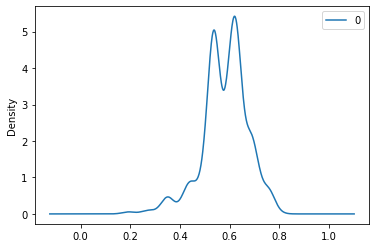

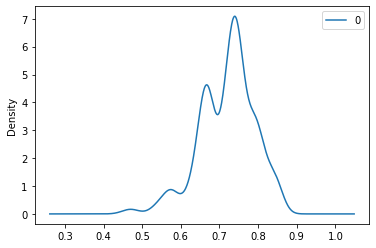

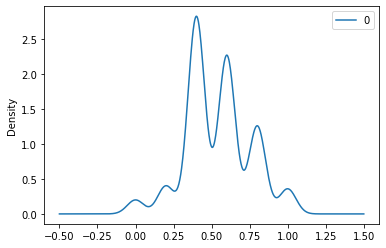

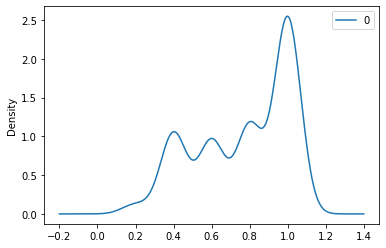

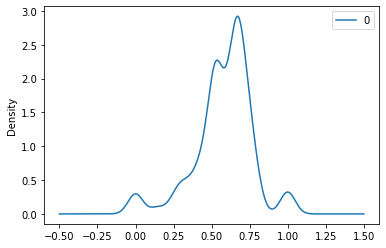

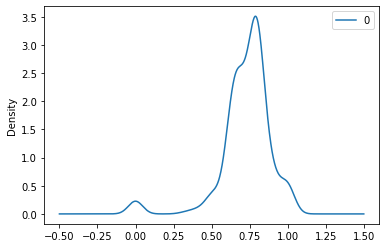

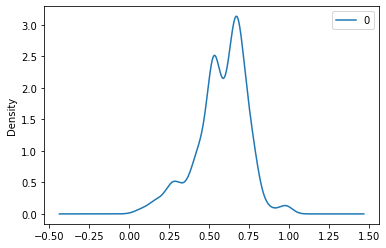

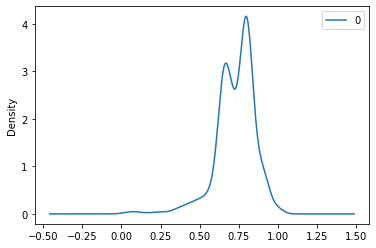

In [13]:
# Imd band

for model in models:

   print("----------", flush=True)
   # retrive curve objects
   line1 = pd.DataFrame(model.predict_proba(X_test_imdband_1)[:, 1]).plot.kde()
   line2 = pd.DataFrame(model.predict_proba(X_test_imdband_0)[:, 1]).plot.kde()

   # retrieve coordinates
   coordinates1 = line1.get_children()[0].get_path().vertices
   coordinates2 = line2.get_children()[0].get_path().vertices

   # area between curve 1 and curve 2 via their coordinates
   area = similaritymeasures.area_between_two_curves(coordinates1, coordinates2)

   # area of the union of the 2 curves (max. pt1 and pt2)
   coord_max = np.maximum(coordinates1, coordinates2) # element-wise
   xaxis = np.zeros((len(coord_max), 2))
   xaxis[:, 0] = np.linspace(0, 1, num=len(coord_max), endpoint=True)

   area_union = similaritymeasures.area_between_two_curves(coord_max, xaxis)

   print("similaritymeasures:", flush=True)
   print(round(area_union - area, 2), flush=True) # intersection area

   print(round((area_union - area)/area_union, 2), flush=True) # intersection area over union

   normalized_coordinates1 = coordinates1/np.linalg.norm(coordinates1)
   normalized_coordinates2 = coordinates2/np.linalg.norm(coordinates2)
   print(round(euclidian_distance(normalized_coordinates1, normalized_coordinates2), 2))
   


   print("min and max:", flush=True)
   intersection_curve = np.minimum(coordinates1, coordinates2)
   intersection_area = similaritymeasures.area_between_two_curves(intersection_curve, xaxis)
   print(round(intersection_area, 2), flush=True) # intersection area
   print(round(intersection_area/area_union, 2), flush=True) # ratio
   print(round(np.linalg.norm(coordinates2 - coordinates1), 2)) # euclidian distance with primitive function, same results no matter the ordi of the substraction

----------
similaritymeasures:
0.59
0.47
0.63
min and max:
0.7
0.55
33.38
----------
similaritymeasures:
0.79
0.61
0.41
min and max:
0.78
0.6
14.01
----------
similaritymeasures:
0.75
0.59
0.31
min and max:
0.77
0.62
12.46
----------
similaritymeasures:
0.81
0.69
0.31
min and max:
0.81
0.69
12.15


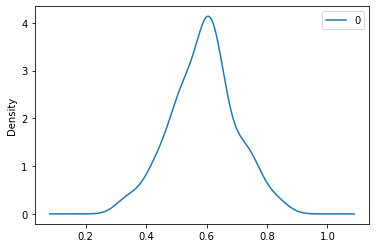

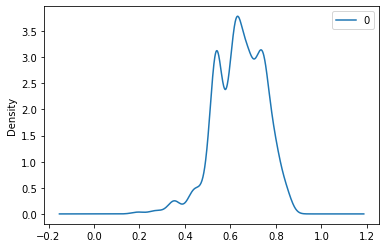

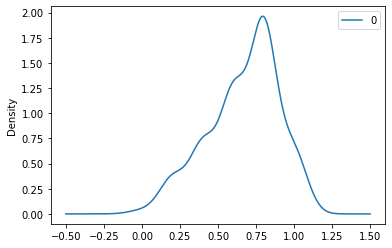

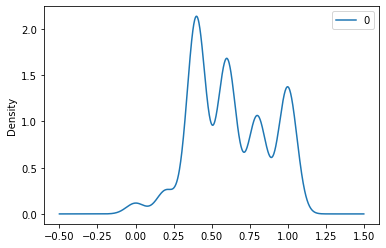

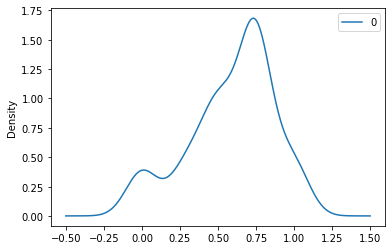

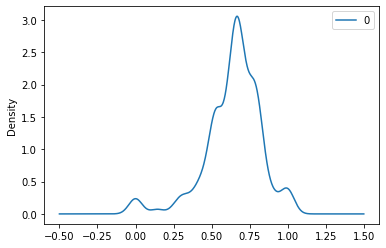

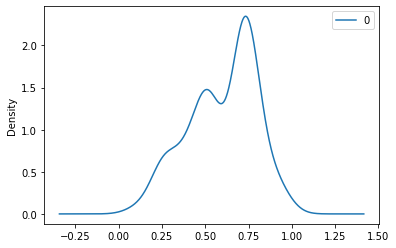

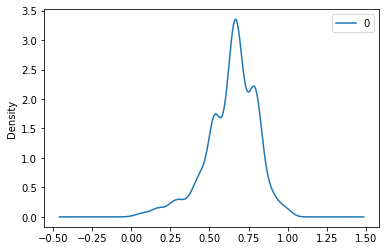

In [14]:
# Disability

for model in models:

   print("----------", flush=True)
   # retrive curve objects
   line1 = pd.DataFrame(model.predict_proba(X_test_disability_1)[:, 1]).plot.kde()
   line2 = pd.DataFrame(model.predict_proba(X_test_disability_0)[:, 1]).plot.kde()

   # retrieve coordinates
   coordinates1 = line1.get_children()[0].get_path().vertices
   coordinates2 = line2.get_children()[0].get_path().vertices

   # area between curve 1 and curve 2 via their coordinates
   area = similaritymeasures.area_between_two_curves(coordinates1, coordinates2)

   # area of the union of the 2 curves (max. pt1 and pt2)
   coord_max = np.maximum(coordinates1, coordinates2) # element-wise
   xaxis = np.zeros((len(coord_max), 2))
   xaxis[:, 0] = np.linspace(0, 1, num=len(coord_max), endpoint=True)

   area_union = similaritymeasures.area_between_two_curves(coord_max, xaxis)

   print("similaritymeasures:", flush=True)
   print(round(area_union - area, 2), flush=True) # intersection area

   print(round((area_union - area)/area_union, 2), flush=True) # intersection area over union

   normalized_coordinates1 = coordinates1/np.linalg.norm(coordinates1)
   normalized_coordinates2 = coordinates2/np.linalg.norm(coordinates2)
   print(round(euclidian_distance(normalized_coordinates1, normalized_coordinates2), 2))
   


   print("min and max:", flush=True)
   intersection_curve = np.minimum(coordinates1, coordinates2)
   intersection_area = similaritymeasures.area_between_two_curves(intersection_curve, xaxis)
   print(round(intersection_area, 2), flush=True) # intersection area
   print(round(intersection_area/area_union, 2), flush=True) # ratio
   print(round(np.linalg.norm(coordinates2 - coordinates1), 2)) # euclidian distance with primitive function, same results no matter the ordi of the substraction

In [15]:
#x1, y1 = np.split(coordinates1, 2, 1)
#x2, y2 = np.split(coordinates2, 2, 1)

## Safety check

In [26]:
mu1, sigma1 = 0, 0.1 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, (1000, 2))

In [49]:
mu2, sigma2 = 0.5, 0.1 # mean and standard deviation
s2 = np.random.normal(mu2, sigma2, (1000, 2))

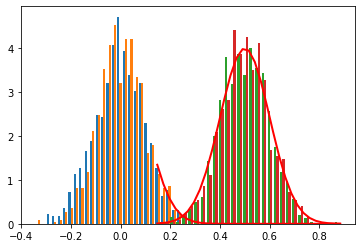

In [50]:
count, bins, ignored = plt.hist(s1, 30, density=True)
count, bins, ignored = plt.hist(s2, 30, density=True)
plt.plot(bins, 1/(sigma1 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu1)**2 / (2 * sigma1**2) ),
         linewidth=2, color='r')
plt.plot(bins, 1/(sigma2 * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu2)**2 / (2 * sigma2**2) ),
    linewidth=2, color='r')

In [39]:
print(similaritymeasures.area_between_two_curves(s1, s2)) # 0.1

19.62169839299725


In [51]:
print(similaritymeasures.area_between_two_curves(s2, s1)) # 0.5

74.77574177879997


In [47]:
print(similaritymeasures.area_between_two_curves(s2, s1)) # 0.8

120.68140048177823


In [46]:
print(similaritymeasures.area_between_two_curves(s1, s1)) 

0.0
